# Вебинар 6. Консультация по курсовому проекту.

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Соревнование заканчивается 13.09.20
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров. 

**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [5]:
TRAIN_DATASET_PATH = './realestatepriceprediction/train.csv'
TEST_DATASET_PATH = './realestatepriceprediction/test.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [7]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [10]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [11]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

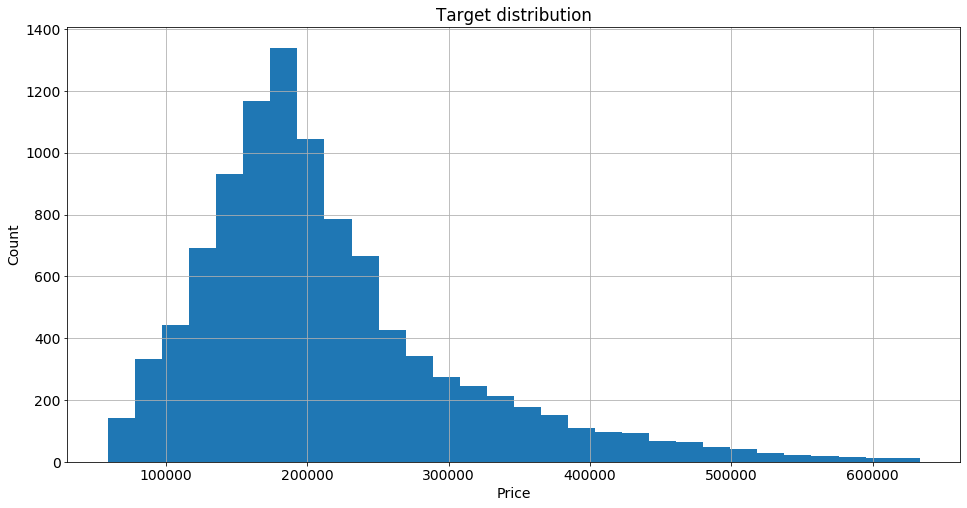

In [13]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [15]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [16]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
209      1
174      1
205      1
117      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [17]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [18]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [19]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов
Что можно делать с ними?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

**Rooms**

In [20]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [21]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,0


In [22]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [23]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**KitchenSquare** 

In [24]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
41.0         2
112.0        2
25.0         2
43.0         2
51.0         2
37.0         2
32.0         2
30.0         2
58.0         2
72.0         1
96.0         1
66.0         1
48.0         1
40.0         1
2014.0       1
35.0         1
60.0         1
78.0         1
27.0         1
84.0         1
62.0         1
42.0         1
63.0         1
39.0         1
1970.0       1
36.0         1
75.0         1
26.0         1
21.0         1
29.0         1
23.0         1
73.0         1
123.0        1
31.0         1
53.0         1
54.0         1
Name: KitchenSquare, dtype: int64

In [25]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [26]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [27]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

**HouseFloor, Floor**

In [28]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [29]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [30]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [31]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [32]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [33]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [34]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [35]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

**HouseYear**

In [36]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
1499        2020
5701        2020
7076        2020
          ...   
7611        1916
910         1914
5111        1912
2656        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [37]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### 3. Обработка пропусков

In [38]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [39]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
2,44.947953,29.197612,3.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
7,80.312926,NaN,3.0
8,64.511437,NaN,3.0
9,46.461409,18.915552,8.0


**LifeSquare**

In [40]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

**Healthcare_1**

In [41]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [42]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков

**Dummies**

In [43]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [44]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [45]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,0,11,1,184966.930730,0,0,0,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,1,16,1,300009.450063,0,0,0,87
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,1,3,1,220925.908524,0,0,0,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,0,5,1,175616.227217,0,0,0,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2,4,1,150226.531644,0,0,0,97


In [46]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [47]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

**MedPriceByDistrict**

In [48]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [49]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,1,184966.930730,0,0,0,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,1,300009.450063,0,0,0,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,3,1,220925.908524,0,0,0,174,1,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,1,175616.227217,0,0,0,179,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,1,150226.531644,0,0,0,97,0,158539.052715


**MedPriceByFloorYear**

In [50]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [51]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       2
1       2
2       2
3       2
4       3
       ..
9995    1
9996    3
9997    3
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [52]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0        (5, 9]
1        (5, 9]
2        (5, 9]
3        (5, 9]
4       (9, 15]
         ...   
9995     (3, 5]
9996    (9, 15]
9997    (9, 15]
9998     (0, 3]
9999     (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [53]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

In [54]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)
train_df.shape, test_df.shape

((10000, 23), (5000, 22))

In [55]:
features_gen = FeatureGenetator()
features_gen.fit(train_df.drop(columns='Price'), train_df['Price'])

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)
train_df.shape, test_df.shape

((10000, 30), (5000, 29))

In [56]:
train_df.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0)

### 5. Отбор признаков

In [57]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_outlier',
 'LifeSquare_nan',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge',
 'floor_cat',
 'year_cat',
 'MedPriceByDistrict',
 'MedPriceByFloorYear']

In [58]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

### 6. Разбиение на train и test

In [59]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

test_df = test_df[feature_names + new_feature_names]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### 7. Построение модели

**Обучение**

In [61]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

**Оценка модели**

Train R2:	0.964
Test R2:	0.764


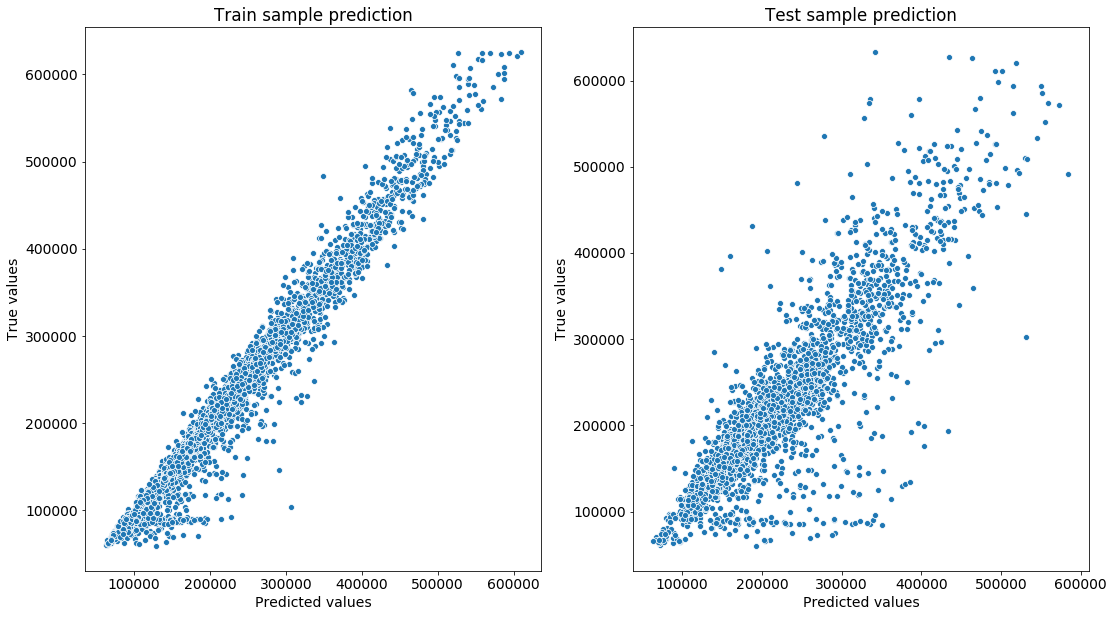

In [62]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

**Кросс-валидация**

In [63]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.76472828, 0.74157915, 0.76020885])

In [64]:
cv_score.mean()

0.7555054291638377

**Важность признаков**

In [65]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
23,MedPriceByDistrict,0.612471
1,Square,0.131539
2,LifeSquare,0.032479
12,Social_3,0.025541
20,DistrictSize,0.024535
5,HouseFloor,0.024139
6,HouseYear,0.024138
24,MedPriceByFloorYear,0.020257
4,Floor,0.018566
3,KitchenSquare,0.016227


### 8. Прогнозирование на тестовом датасете

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [66]:
test_df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear
0,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,1,1,...,1,0,0,0,0,179.0,0,1,166809.665642,192302.751941
1,2.0,69.263183,63.263183,3.0,1,1.0,1977,0.075779,1,1,...,1,0,1,0,1,114.0,0,1,243031.695525,179023.592042
2,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,1,1,...,1,0,0,0,0,7.0,0,0,249667.052894,336343.526425
3,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,1,1,...,1,0,0,0,0,97.0,0,0,222227.584211,252040.974798
4,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,1,1,...,0,0,0,0,0,851.0,0,1,118349.682906,210878.523976


In [67]:
submit = pd.read_csv('./realestatepriceprediction/sample_submission.csv')
submit.head()

,Id,Price
0,725,200000.0
1,15856,200000.0
2,5480,200000.0
3,15664,200000.0
4,14275,200000.0


In [68]:
predictions = rf_model.predict(test_df)
predictions

array([149618.22990517, 214531.6651615 , 214700.34238247, ...,
       315494.71645412, 194129.05645188, 157679.46241424])

In [69]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,725,149618.229905
1,15856,214531.665161
2,5480,214700.342382
3,15664,329366.567583
4,14275,148028.747600


In [70]:
submit.to_csv('rf_submit.csv', index=False)